We want to create our own perciever resampler. Basically it takes a vision encoder, and an LM and places itself in between to create conditioning inputs that allow the LM to have information about the incoming images. 

![Firefox 2024-10-29 10.42.53.png](<attachment:Firefox 2024-10-29 10.42.53.png>)

The biggest model is 80 billion parameters which is fucking insane - curious that this doesn't impact people as much as the LLMs.

![CleanShot 2024-10-29 at 10.48.32@2x.png](<attachment:CleanShot 2024-10-29 at 10.48.32@2x.png>)

Their main contribution is approaching the attention function that is above in a novel way
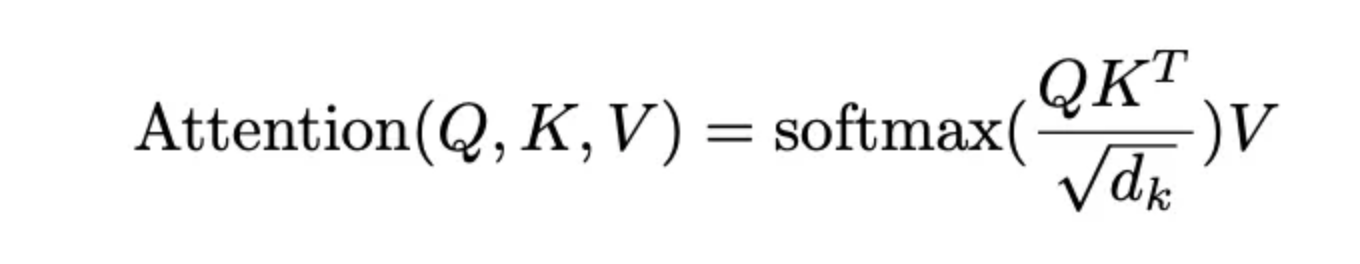
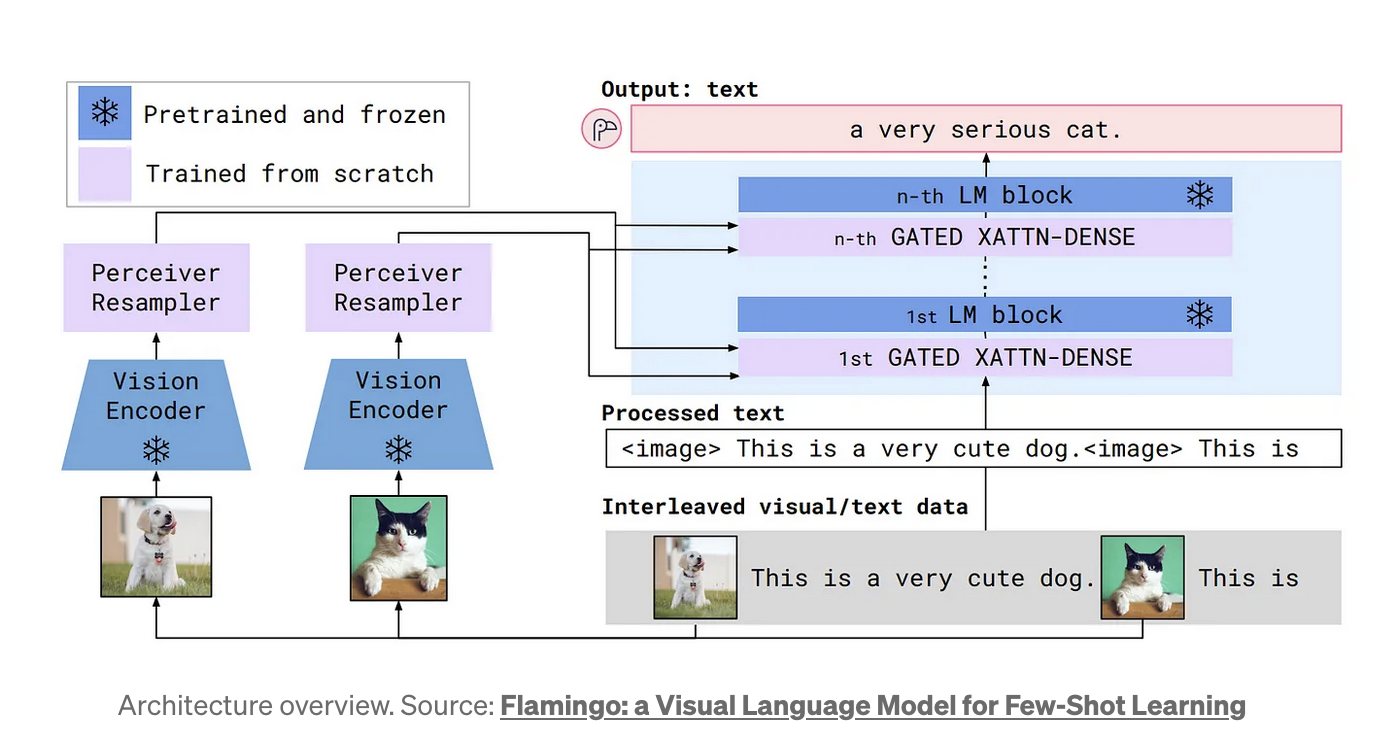

The issue here is that the complexity scales squared with the sequence size. Need a new way of calculating if we want a bigger context window to adapt to images for example.

![CleanShot 2024-10-29 at 10.56.52@2x.png](<attachment:CleanShot 2024-10-29 at 10.56.52@2x.png>)
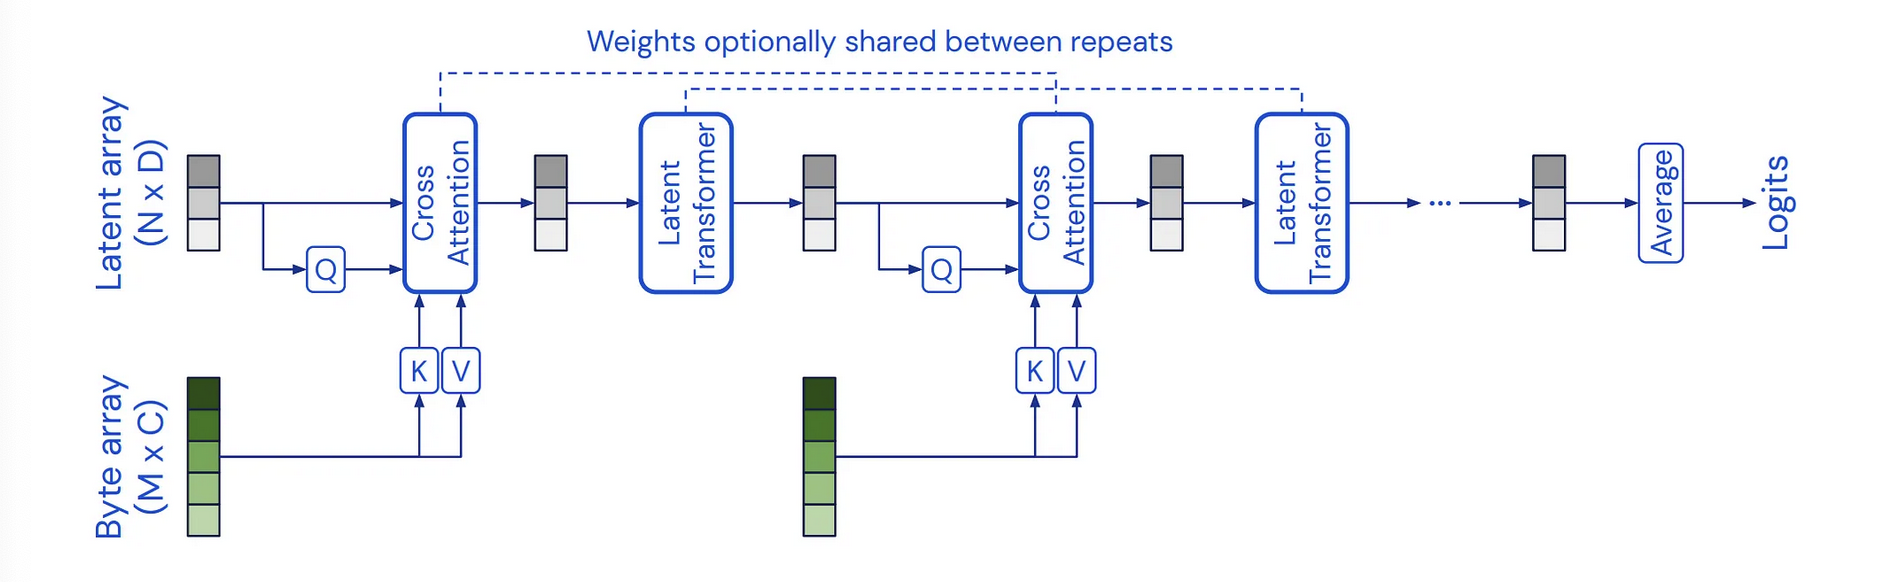

Above, the incoming Byte array is for example an image (50k for 224x224 images). This would be too expensive for the above attention function. Instead, using a fixed size array for the query of N latents with dimension D allows to have a computation of 50k x N. (For example 512). The computation then becomes O(MN) and O(N**2).

Apparently this would allow for the stacking of many transformer layers ? The Perciever part of a model is what takes a variable amount of features but outputs a fixed number of tokens.



![CleanShot 2024-10-29 at 11.15.00@2x.png](<attachment:CleanShot 2024-10-29 at 11.15.00@2x.png>)

A more understandable picture
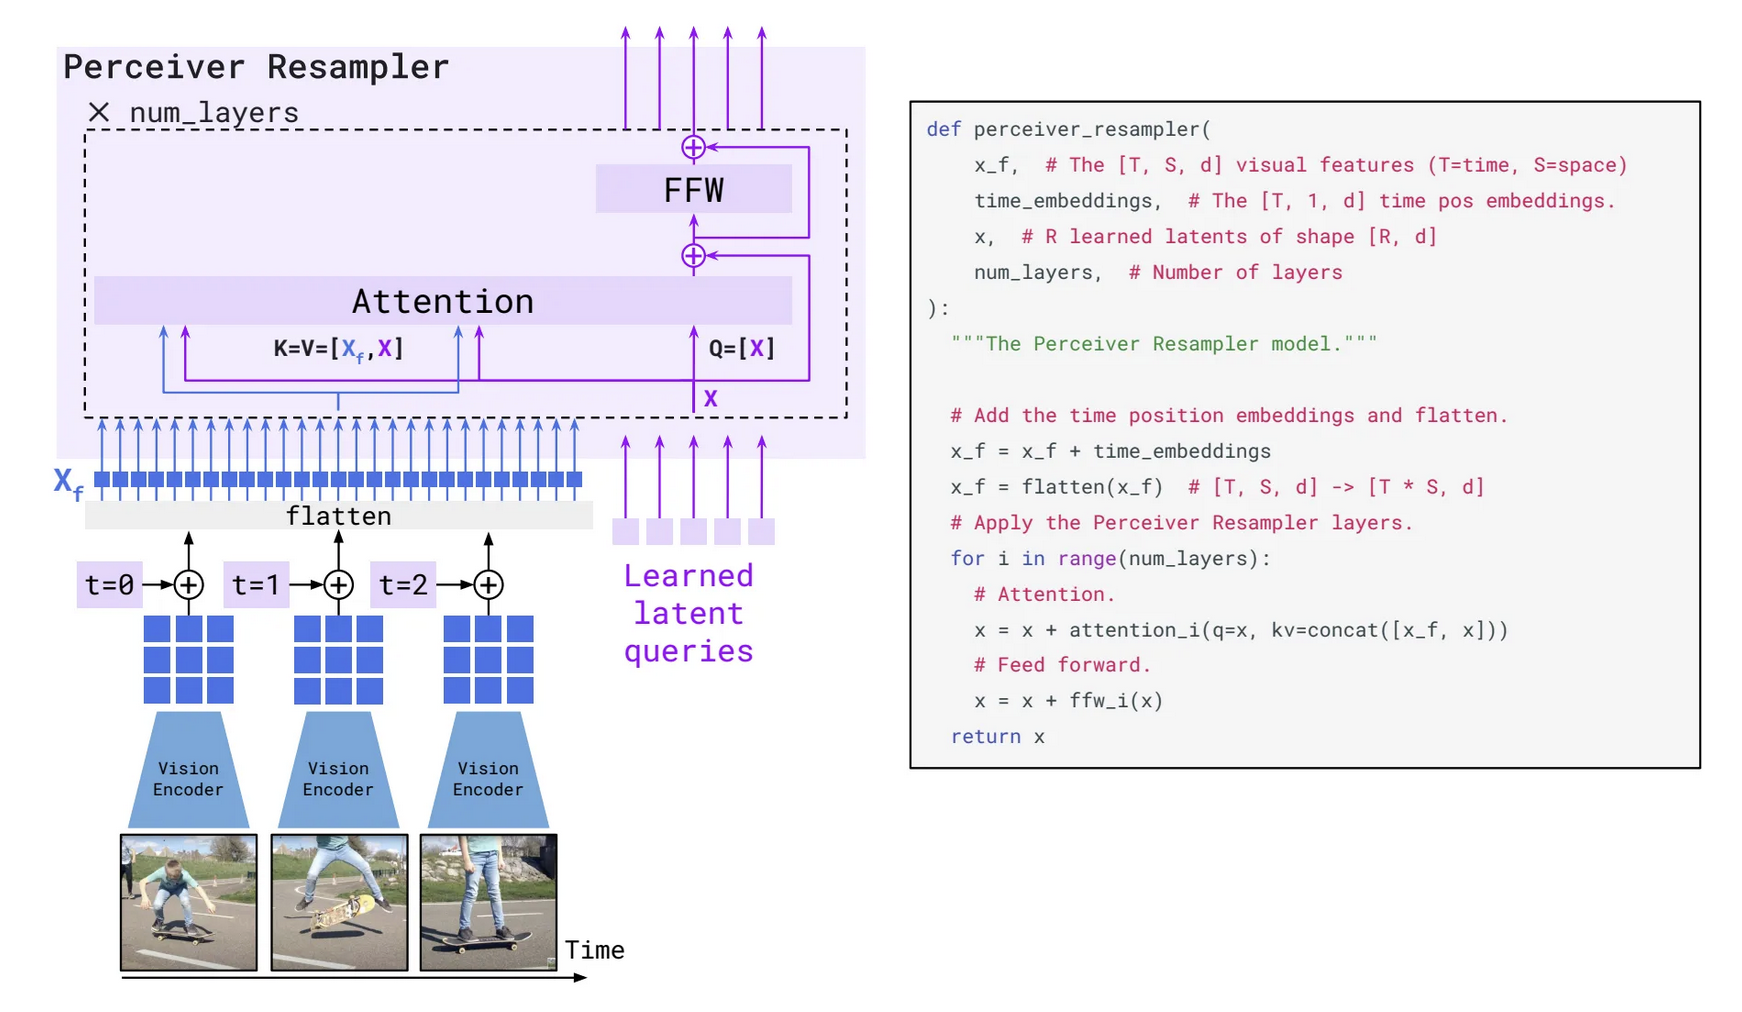

Because the LM model suddenly has latents coming in from the images on which it will be conditioned on, tanh gating is used with $alpha$ set to zero, and left as a model parameter that evolves with time.

![CleanShot 2024-10-29 at 11.18.23@2x.png](<attachment:CleanShot 2024-10-29 at 11.18.23@2x.png>)

Gated means that the LM is kept intact at init for improved stability and performance.

![CleanShot 2024-10-29 at 11.23.06@2x.png](<attachment:CleanShot 2024-10-29 at 11.23.06@2x.png>)

The masked cross attention seems to be really strange though - doesn't this have a negative impact on audio for example ? What about taking two last ones instead ?

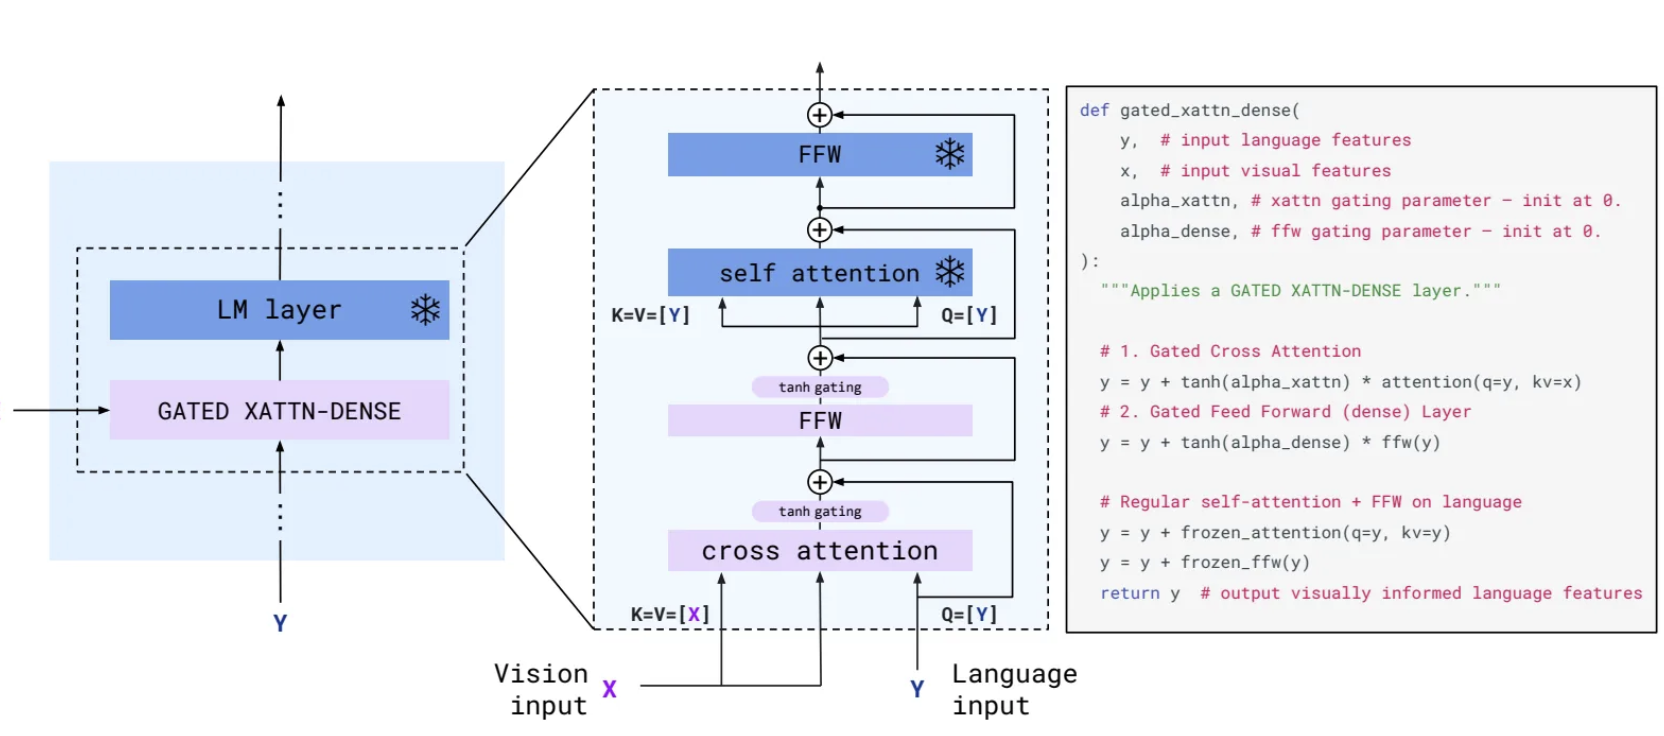
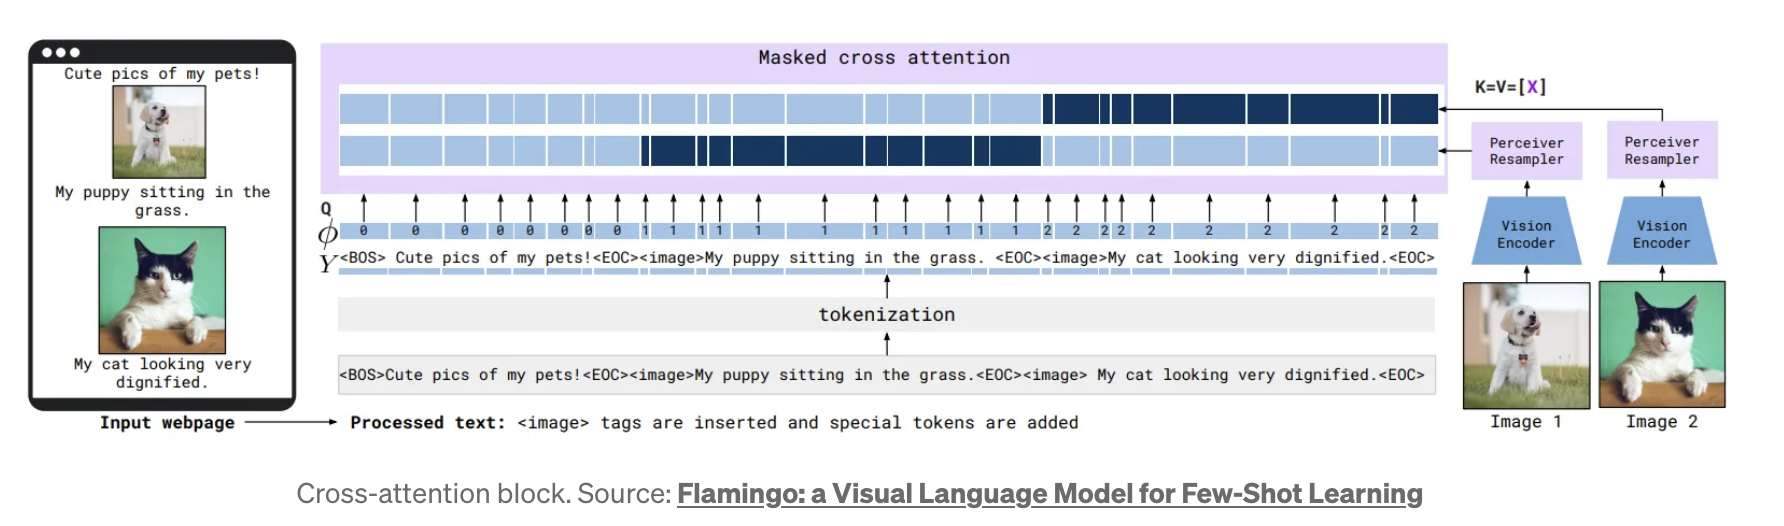

Here instead of implementing our own version of the MultiheadAttention, we're going to use the version provided by the library equinox.

In [14]:
import jax
import jax.numpy as jnp
import equinox as eqx
import equinox.nn as nn

# class GEGLU(eqx.Module):
#     def __call__(self, x):
#         # Split along the last dimension. This is because in the paper they mention that they concatenate the keys and values before passing them on.
#         x, gate = jax.numpy.split(x, 2, axis=-1)
#         return jax.nn.selu(gate) * x

class Attention(eqx.Module):
    # This projects the incoming image into the latent dimensions.
    to_kv: nn.Linear
    # We don't need these as they'll be the latents.
    # Project the latents into the dim of the head.
    to_q: nn.Linear
    # k_ff: nn.Linear
    # v_ff: nn.Linear
    to_out: nn.Linear

    def __init__(self, latent_dim, context_dim, dim_head, key):
        key1, key2, key3 = jax.random.split(key, 3)
        self.to_kv = nn.Linear(context_dim, dim_head, key=key1)
        self.to_out = nn.Linear(dim_head, latent_dim, key=key2)
        self.to_q = nn.Linear(latent_dim, dim_head, key=key3)

    def __call__(self, latents, x):
        q = jax.vmap(self.to_q)(latents)  # Shape: (num_latents, dim_head)
        k = jax.vmap(self.to_kv)(x)       # Shape: (M, dim_head)
        v = jax.vmap(self.to_kv)(x)       # Shape: (M, dim_head)

        qk = jnp.matmul(q, jnp.transpose(k))  # Shape: (num_latents, M)

        attn = jax.nn.softmax(qk, axis=-1)  # Shape: (num_latents, M)
        out = jnp.matmul(attn, v)           # Shape: (num_latents, dim_head)
        return jax.vmap(self.to_out)(out)

class Block(eqx.Module):
    attn: nn.MultiheadAttention
    layer1: nn.Linear
    layer2: nn.Linear

    def __init__(self, latent_dim, context_dim, num_heads, key):
        key1, key2, key3 = jax.random.split(key, 3)

        self.attn = Attention(latent_dim, context_dim, dim_head=20, key=key1)
        # self.attn = Attention(num_heads, query_size=context_dim, key_size=latent_dim, value_size=latent_dim, output_size=latent_dim, qk_size=latent_dim, key=key1)
        self.layer1= nn.Linear(latent_dim, 2 * latent_dim, key=key2)
        self.layer2=nn.Linear(2 * latent_dim, latent_dim, key=key3)            

    def __call__(self, latents, x):
        y = self.attn(latents, x) + latents
        y = jax.vmap(self.layer1)(y)
        y = jax.nn.selu(y)
        y = jax.vmap(self.layer2)(y) + latents
        return y


class PercieverResampler(eqx.Module):
    latents: jax.Array # These are the learnable latents
    layers: list

    def __init__(self, num_latents, latent_dim, context_dim, num_heads, depth, key):
        self.latents = jax.random.normal(key, (num_latents, latent_dim))
        
        self.layers = [
            Block(latent_dim, context_dim, num_heads, key) for _ in range(depth)
        ]

    def __call__(self, context):
        y = self.latents
        for layer in self.layers:
            print(f"Shape before coming out: {y.shape}")
            y = layer(y, context)
            
        return y

In [16]:
@jax.jit
@eqx.filter_value_and_grad
def loss(model, x):
    result = jax.vmap(model)(x)
    return jax.numpy.mean(result)

key1, key2 = jax.random.split(jax.random.PRNGKey(69), 2)

x = jax.random.normal(key1, (64, 32*32, 3))

model = PercieverResampler(num_latents=10, latent_dim=100, context_dim=3, num_heads=16, depth=2, key=key2)

result, grad = loss(model, x)

Shape before coming out: (10, 100)
Shape before coming out: (10, 100)
